# import modules

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.python.keras.layers import LSTM 
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.layers import Dense 
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# 유동인구 data 불러오기

In [16]:
df=pd.read_csv("C:/Users/wnduq/Desktop/유동인구_최종/유동인구_부전1동.csv",encoding='euc-kr')
df

,Unnamed: 0,남10대,여10대,남20대,여20대,남30대,여30대,남40대,여40대,남50대,여50대,남60대,여60대,남70대,여70대,time,label
0,1,905.809767,867.335419,4223.613759,4277.240753,4180.953422,4115.471699,4088.688921,3910.448675,4569.029456,4732.379496,3780.892805,3699.192315,1579.788403,1741.155109,1,10
1,2,915.703151,826.247217,4280.180663,4325.748017,4017.522110,4218.581633,4161.656972,3999.767768,4769.520924,4690.280686,3737.031915,3860.804233,1907.704142,1969.250568,2,9
2,3,931.680078,1219.264692,4464.528678,4539.528097,4431.449251,4490.067514,4167.246254,4478.487349,4942.875147,5173.688702,4074.921199,4013.091387,1891.625724,1982.545928,3,10
3,4,1082.323717,1134.101183,4988.650671,4997.976477,4934.094061,4870.464613,4540.073216,4763.800299,5493.627629,5503.141356,4493.226533,4391.836884,2369.931996,1788.751365,4,10
4,5,1300.297861,975.962514,5307.215472,5343.265054,5183.591120,5131.022234,5168.861198,5251.045263,6055.368323,6111.581029,4617.457724,4703.998305,2318.490557,2330.843347,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25531,25532,942.032794,962.913564,3963.286317,4052.804238,3696.428185,3781.943405,3456.584867,3535.895646,3422.814365,3503.932141,3037.275349,3107.920213,1627.015612,1665.153305,25532,15
25532,25533,918.533195,940.286290,3857.965039,3947.819767,3601.931740,3684.245235,3364.934030,3443.626433,3332.220872,3410.742119,2958.386292,3025.314540,1585.535664,1620.458784,25533,15
25533,25534,755.560838,773.292828,3174.366754,3246.801462,2962.212012,3028.732201,2769.674694,2833.394602,2742.908149,2804.700356,2432.895397,2489.785075,1302.134861,1333.540770,25534,15
25534,25535,648.474448,663.432829,2722.174284,2785.433673,2540.465927,2598.176705,2373.822485,2428.337675,2351.811276,2405.552696,2084.397407,2134.486842,1118.203221,1143.230530,25535,15


# 입력데이터,출력데이터 생성

48시간 간격의 sliding window 생성, minmax saciling으로 학습속도 높인다. 

In [17]:
#feature생성..

scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame(scaler.fit_transform(np.array(df.iloc[:,1:15])))


def create_dataset(dataset, look_back):
    
    total=[]
    x_data=pd.DataFrame(np.zeros((25487,48)))
    y_data=pd.DataFrame(np.zeros((25487,1)))
    
    
    for j in range(14) :

        tmp_data = np.array(dataset.iloc[:,j:j+1])
        dataX, dataY = [], []
        for i in range(len(tmp_data)-look_back-1):
            a = tmp_data[i:(i + look_back)]
            dataX.append(a)
            dataY.append(tmp_data[i + look_back])
        
        x=pd.DataFrame((np.array(dataX).reshape(25487,48)))
        y=pd.DataFrame((np.array(dataY).reshape(25487,1)))
        x_data=pd.concat([x_data,x],axis=1)
        y_data=pd.concat([y_data,y],axis=1)
    
    
    return  x_data,y_data

#2일치로 1시간 예측(슬라이드 원도우)
look_back = 24*2 
temp=create_dataset(df,look_back)
x_data=temp[0]
y_data=temp[1]


x_data.columns=range(720)
y_data.columns=range(15)

x_data=np.array(x_data.drop(x_data.columns[0:48], axis='columns'))
y_data=np.array(y_data.drop(y_data.columns[[0]], axis='columns'))
x_data.shape,y_data.shape


((25487, 672), (25487, 14))

# 모델생성 및 학습
 
trainset(2년),testset(2개월)으로 LSTM모델학습,
배치당 20분소요...

In [19]:
##test,train 분할(2년치만 학습)

num_train = 24*28*24
num_test = 24*28*2

x_train = x_data[0:num_train]
x_test = x_data[num_train:num_train+num_test-1]

y_train = y_data[0:num_train]
y_test = y_data[num_train:num_train+num_test-1]

num_x_signals = x_data.shape[1]
num_x_signals

num_y_signals = 1
num_y_signals



##모델링(simple_ver.)



K.clear_session()
   
model = Sequential() # Sequeatial Model 
model.add(LSTM(512, input_shape=(24*2*14,1))) # (timestep*feature,1) 
model.add(Dense(14)) # output = 14
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()



x_train = x_train.reshape(x_train.shape[0],24*2*14,1)


##callback
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./last_f/',histogram_freq=0,write_graph=True)


model.fit(x_train, y_train, epochs=100,
          batch_size=50, verbose=1, callbacks=[early_stop,callback_tensorboard])#gpu렘용량부족 batch_size=50한계...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1052672   
_________________________________________________________________
dense (Dense)                (None, 14)                7182      
Total params: 1,059,854
Trainable params: 1,059,854
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16128/16128 [==============================] - 1312s 81ms/sample - loss: 0.0169
Epoch 2/100
16128/16128 [==============================] - 1297s 80ms/sample - loss: 0.0041
Epoch 3/100
16128/16128 [==============================] - 1297s 80ms/sample - loss: 0.0026
Epoch 4/100
16128/16128 [==============================] - 1298s 80ms/sample - loss: 0.0024
Epoch 5/100
16128/16128 [==============================] - 1297s 80ms/sample - loss: 0.0023
Epoch 6/100
16128/16128 [=======================

# ploting 통한 예측력 확인

trainingset에 대한 적합, prediction의 정확도 확인

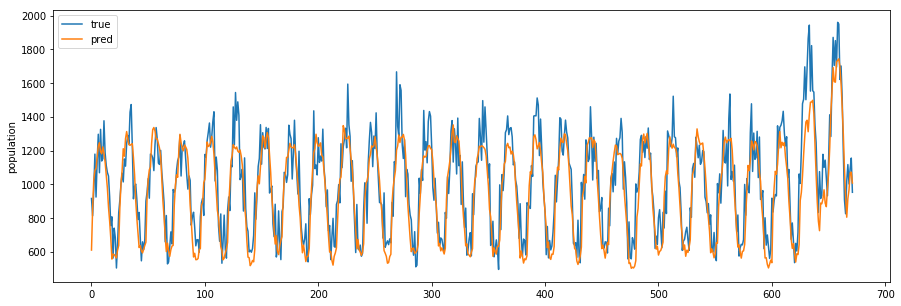

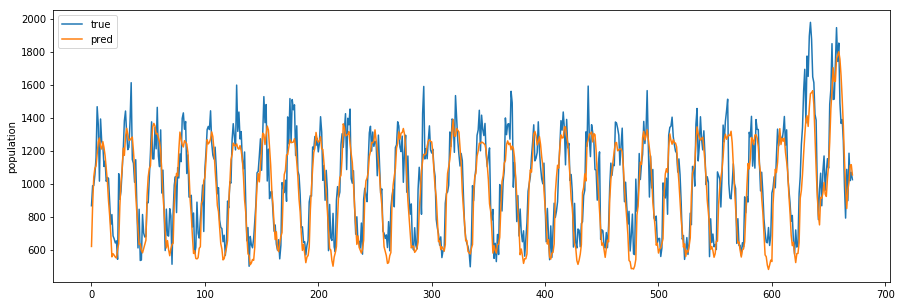

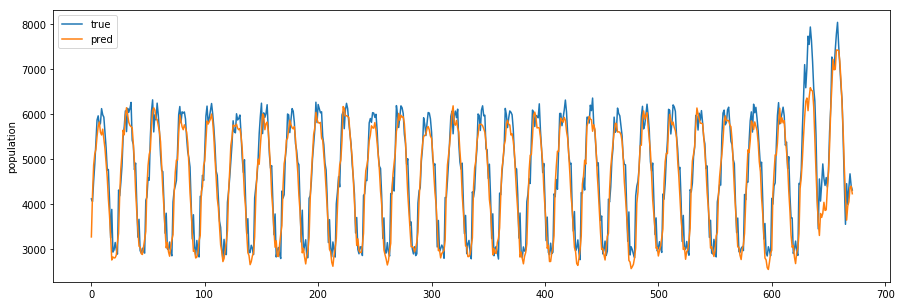

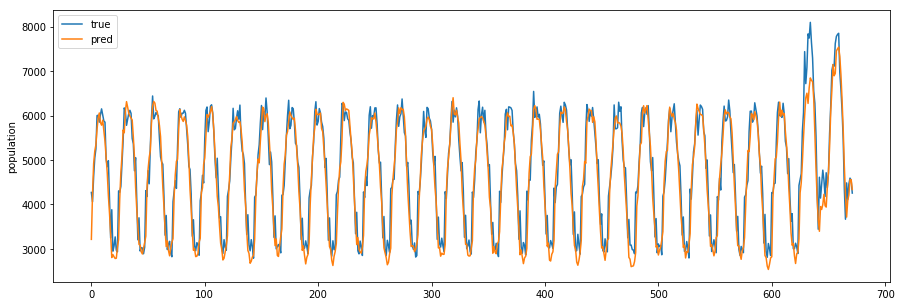

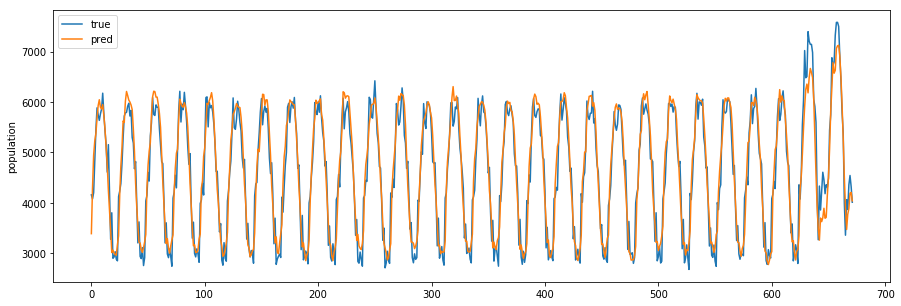

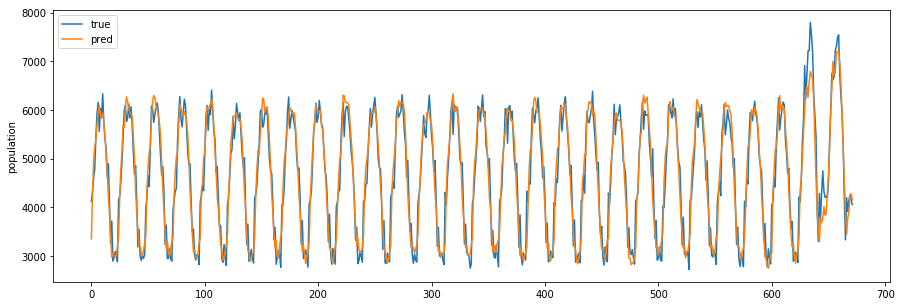

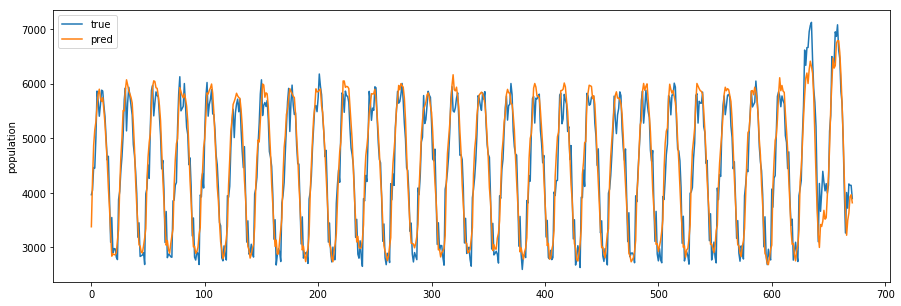

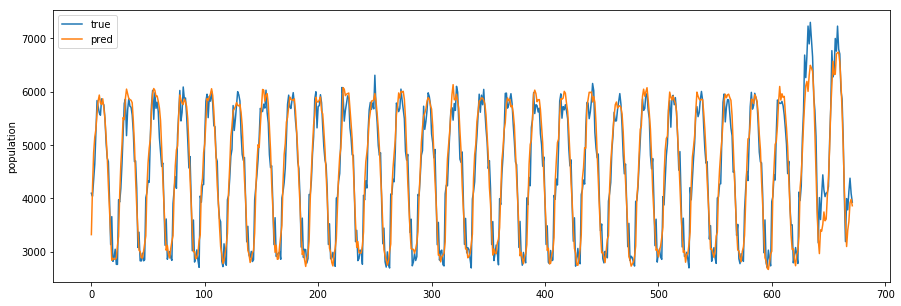

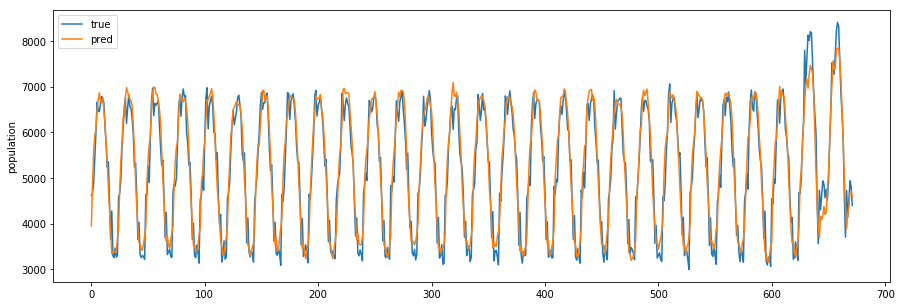

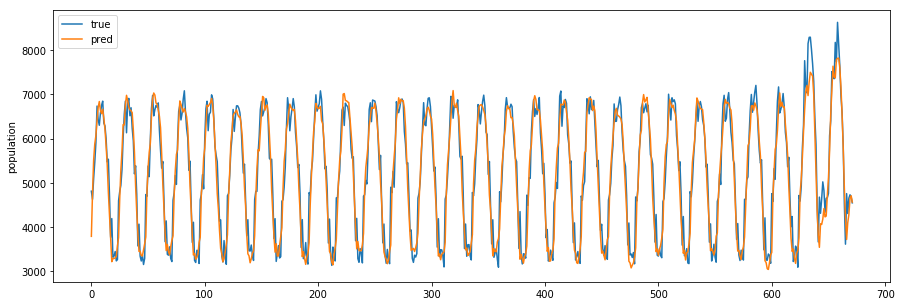

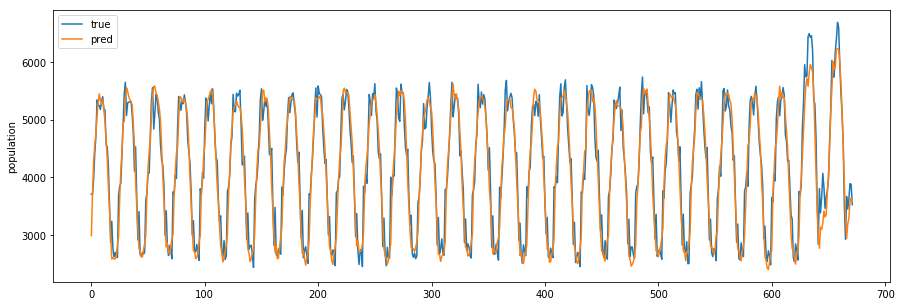

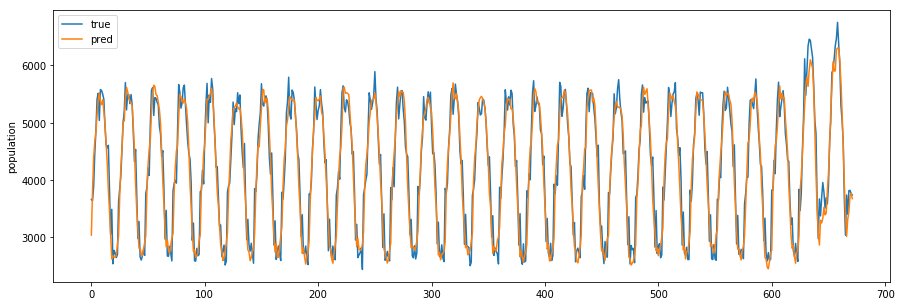

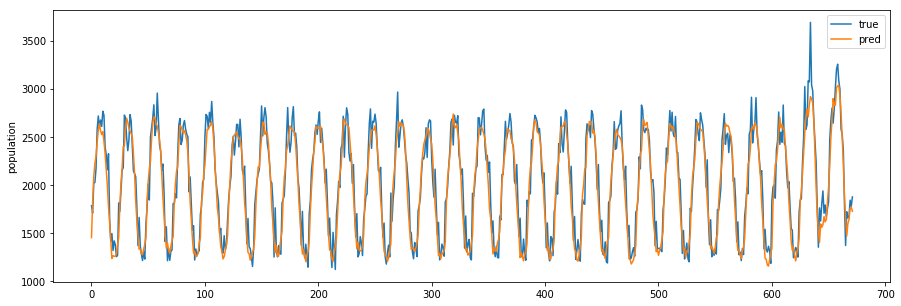

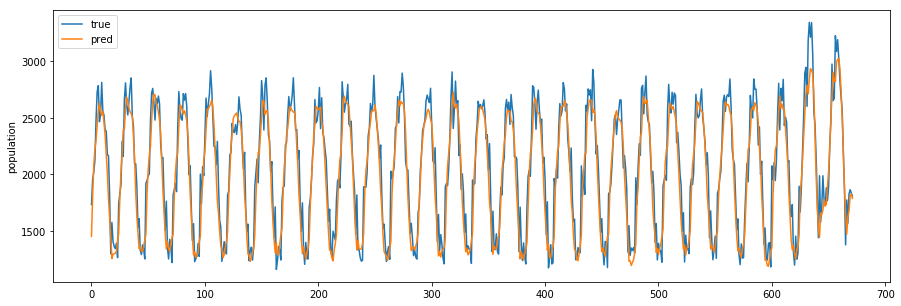

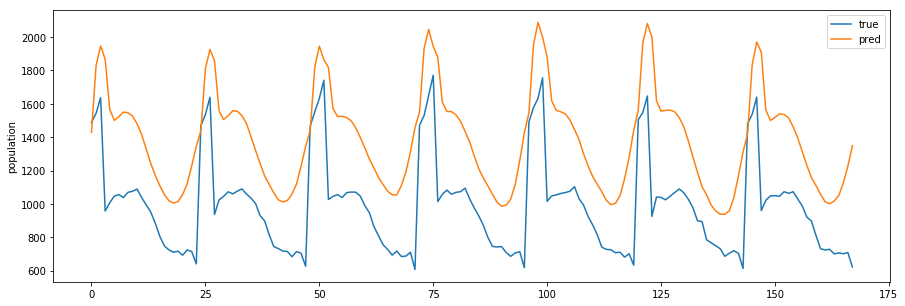

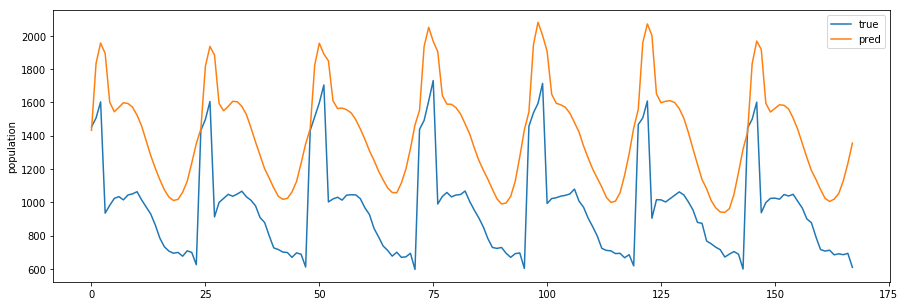

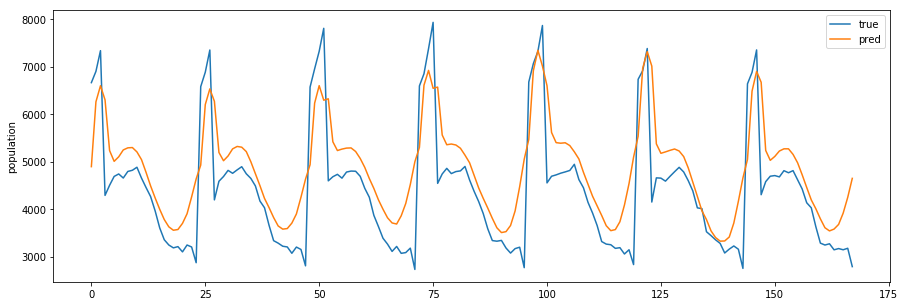

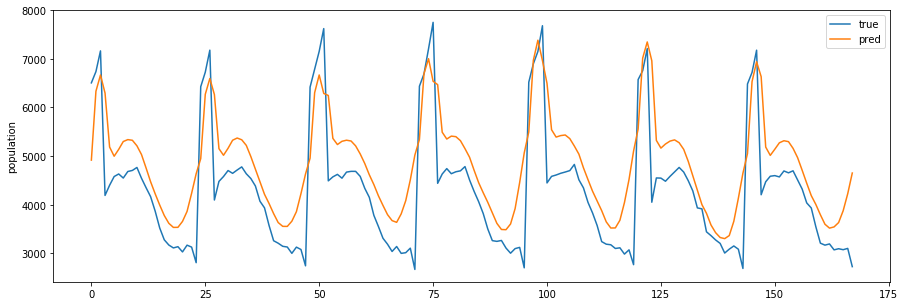

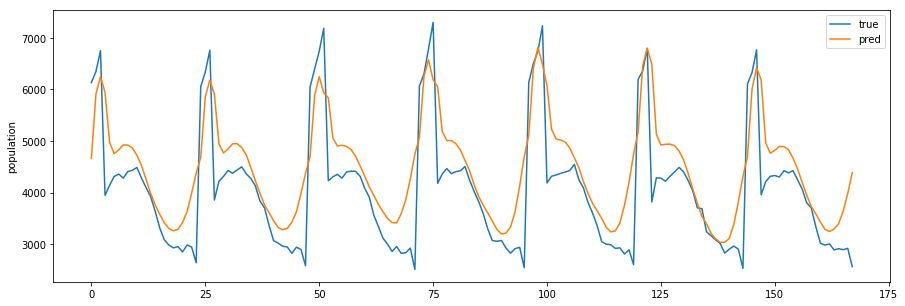

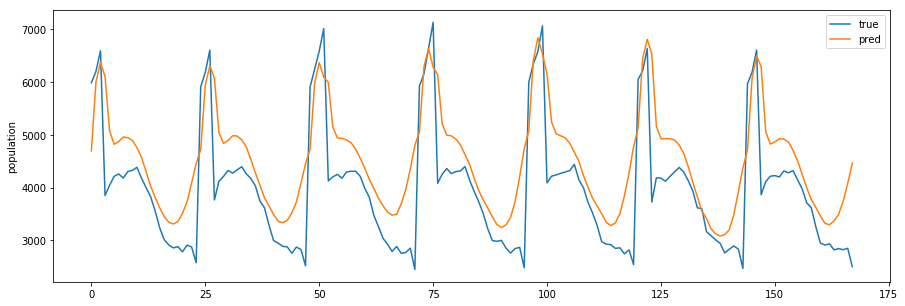

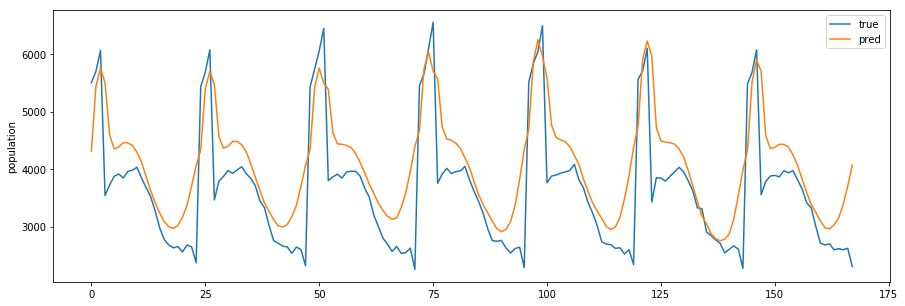

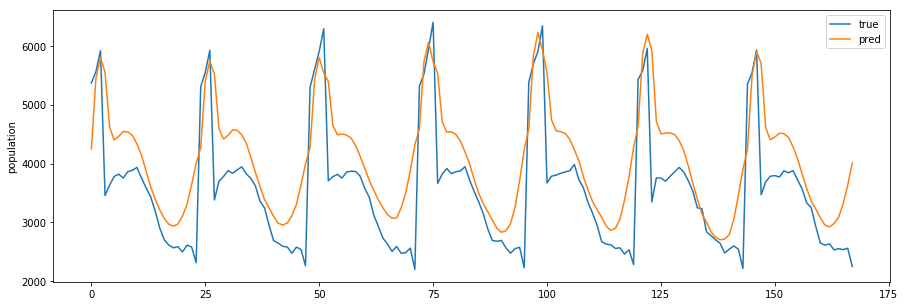

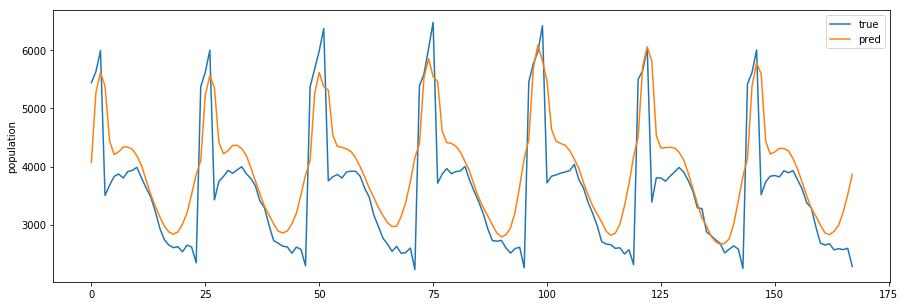

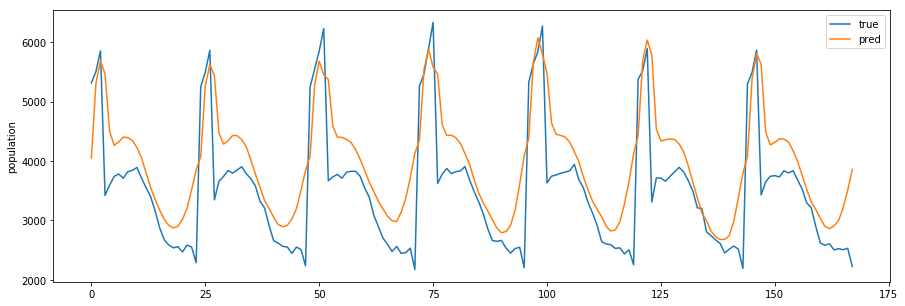

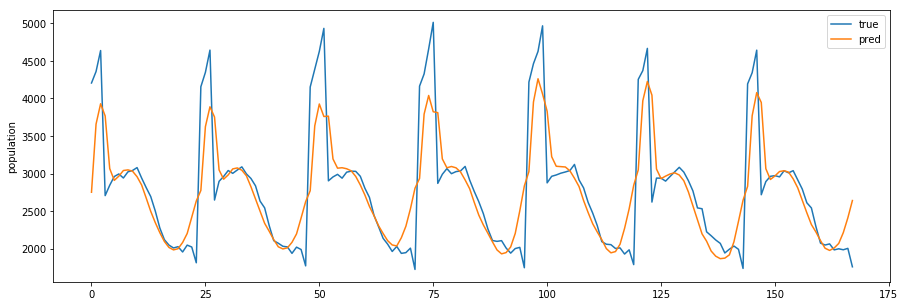

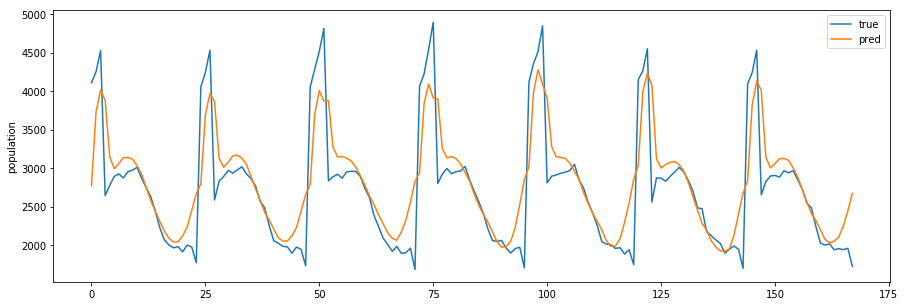

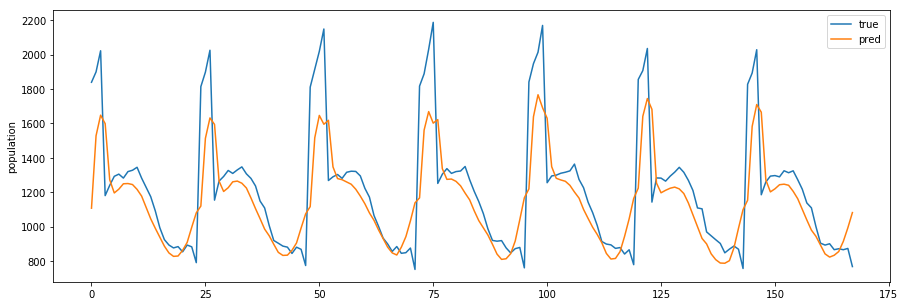

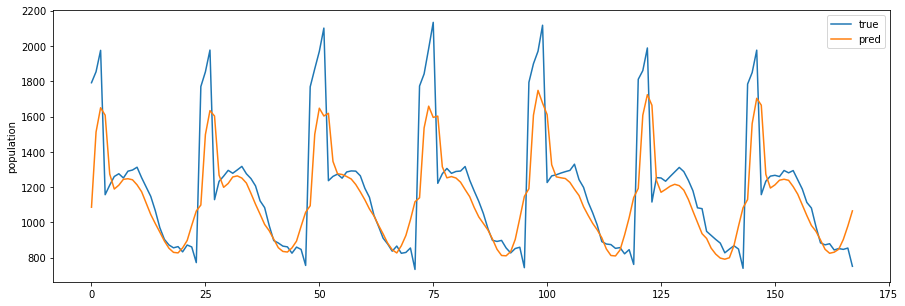

In [22]:
##예측

def plot_comparison(start_idx, length, train):

    if train:
        x = x_train
        y_true = y_train
    else:
        x = x_test.reshape(x_test.shape[0],24*2*14,1)
        y_true = y_test
    end_idx = start_idx + length
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    y_pred = model.predict(x)
    y_pred=scaler.inverse_transform(y_pred)
    y_true=scaler.inverse_transform(y_true)
    
    for signal in range(14):
        signal_pred = y_pred[:,signal]
        signal_true = y_true[:,signal]
        plt.figure(figsize=(15,5))
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        plt.ylabel("population")
        plt.legend()
        plt.show()
    
    

###training set에대해
plot_comparison(0, length=24*28, train=True)
###predict
plot_comparison(0, length=24*7, train=False)

# 모델저장

In [24]:
from tensorflow.python.keras.models import load_model
model.save("LSTM_COM_MODEL_부전1동.h5")